In [1]:
import requests
import json, sys
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
from scipy.spatial import distance
from scipy import spatial
import mpu
from joblib import Parallel, delayed
from heapq import heappush, heappop

# Edinburgh transportation network extraction #

**Author:** Ruitao Yi, Abhirup Ghosh  
**Date:** 2019.08.11

## Aims ##

- Use the bus stop name to plot the transportation network
- The distance metric should be harversine rather than Euclidean by using latitude and longitude
- The transportation network should be model as directed graph since the forward and backward path for the same bus line are not exactly the same sometimes. However, this directed graph can be approximately regarded as undirected graph since in most of the cases the forward and the backward path are the same. 

# Step 1: load the routes and bus stops, next get the graph 

### make sure everything is prepared properly 

In [2]:
routes = pickle.load(open("routes.p", "rb"))
bus_stops = pickle.load(open("bus_stops.p", "rb"))

graph = nx.Graph()
for stop_name in bus_stops.keys():
    graph.add_node(stop_name)

for name in list(routes.keys()):
#     print(name)
    route = routes[name]
    for ix in range(len(route)-1):
        v1, v2 = route[ix], route[ix+1]
        if (graph.has_edge(v1, v2) == False):
#             print(v1)
            lat1, lon1 = bus_stops[v1]
            lat2, lon2 = bus_stops[v2]
            weight = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
            graph.add_edge(v1, v2, weight=weight)

/afs/ece.cmu.edu/usr/ruitaoy/miniconda3/envs/summer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


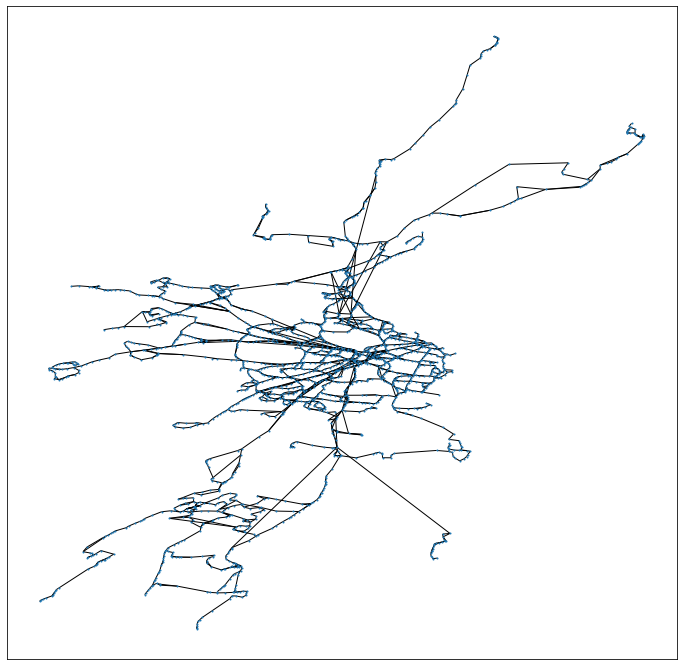

In [3]:
def plot_graph(graph):
    fig, ax = plt.subplots(figsize=(12,12))
    nx.draw_networkx(graph, pos=bus_stops, ax=ax, with_labels=False, node_size=1)

plot_graph(graph)

# Step 2: Compute the route for any two arbitrary points in the graph   

- Note that I modified the KDTree implementation by replacing the minkowski distance with haversine distance

In [4]:
# How to get a kdtree from all nodes (or bus stops) in the network 
def prepare_routing(bus_stops, routes):
    stop_ids, stop_locs = np.array([]), np.array([])
    for name in bus_stops.keys():
        stop_ids = np.append(stop_ids, name)
        if (len(stop_locs) == 0):
            stop_locs = bus_stops[name]
        else:
            stop_locs = np.vstack((stop_locs, bus_stops[name]))
    kdtree = spatial.KDTree(stop_locs)
    return kdtree, stop_ids

In [5]:
# here is my core modification: I changed the original minkowski distance with haversine distance
def haversine_distance_p(x, y, p=2):
    x = np.asarray(x).tolist()
    y = np.asarray(y).tolist()
    if p == np.inf:
        return np.amax(np.abs(y-x), axis=-1)
    elif p == 1:
        return np.sum(np.abs(y-x), axis=-1)
    else:
        return np.asarray(list(map(lambda q: mpu.haversine_distance((q[0][0], q[0][1]),(q[1][0], q[1][1])), list(zip(x,y)))))**p

In [6]:
# I simply replaced all minkowski distance with haversine distance
def __new_query(kdtree, x, k=1, eps=0, p=2, distance_upper_bound=np.inf):

    side_distances = np.maximum(0,np.maximum(x-kdtree.maxes,kdtree.mins-x))
    if p != np.inf:
        side_distances **= p
        min_distance = np.sum(side_distances)
    else:
        min_distance = np.amax(side_distances)

    q = [(min_distance,
          tuple(side_distances),
          kdtree.tree)]
    neighbors = []

    if eps == 0:
        epsfac = 1
    elif p == np.inf:
        epsfac = 1/(1+eps)
    else:
        epsfac = 1/(1+eps)**p

    if p != np.inf and distance_upper_bound != np.inf:
        distance_upper_bound = distance_upper_bound**p

    while q:
        min_distance, side_distances, node = heappop(q)
        if isinstance(node, kdtree.leafnode):
            # brute-force
            data = kdtree.data[node.idx]
            ds = haversine_distance_p(data,x[np.newaxis,:],p)
            for i in range(len(ds)):
                if ds[i] < distance_upper_bound:
                    if len(neighbors) == k:
                        heappop(neighbors)
                    heappush(neighbors, (-ds[i], node.idx[i]))
                    if len(neighbors) == k:
                        distance_upper_bound = -neighbors[0][0]
        else:
            # we don't push cells that are too far onto the queue at all,
            # but since the distance_upper_bound decreases, we might get
            # here even if the cell's too far
            if min_distance > distance_upper_bound*epsfac:
                # since this is the nearest cell, we're done, bail out
                break
            # compute minimum distances to the children and push them on
            if x[node.split_dim] < node.split:
                near, far = node.less, node.greater
            else:
                near, far = node.greater, node.less

            # near child is at the same distance as the current node
            heappush(q,(min_distance, side_distances, near))

            # far child is further by an amount depending only
            # on the split value
            sd = list(side_distances)
            if p == np.inf:
                min_distance = max(min_distance, abs(node.split-x[node.split_dim]))
            elif p == 1:
                sd[node.split_dim] = np.abs(node.split-x[node.split_dim])
                min_distance = min_distance - side_distances[node.split_dim] + sd[node.split_dim]
            else:
                sd[node.split_dim] = np.abs(node.split-x[node.split_dim])**p
                min_distance = min_distance - side_distances[node.split_dim] + sd[node.split_dim]

            # far child might be too far, if so, don't bother pushing it
            if min_distance <= distance_upper_bound*epsfac:
                heappush(q,(min_distance, tuple(sd), far))

    if p == np.inf:
        return sorted([(-d,i) for (d,i) in neighbors])
    else:
        return sorted([((-d)**(1./p),i) for (d,i) in neighbors])

In [7]:
# Now this one is the new kdtree query function. Compared to the previous one, this query function uses  
# haversine distance instead of minkowski distance
def new_query(kdtree, x, k=1, eps=0, p=2, distance_upper_bound=np.inf):
    x = np.asarray(x)
    if np.shape(x)[-1] != kdtree.m:
        raise ValueError("x must consist of vectors of length %d but has shape %s" % (kdtree.m, np.shape(x)))
    if p < 1:
        raise ValueError("Only p-norms with 1<=p<=infinity permitted")
    retshape = np.shape(x)[:-1]
    if retshape != ():
        if k is None:
            dd = np.empty(retshape,dtype=object)
            ii = np.empty(retshape,dtype=object)
        elif k > 1:
            dd = np.empty(retshape+(k,),dtype=float)
            dd.fill(np.inf)
            ii = np.empty(retshape+(k,),dtype=int)
            ii.fill(kdtree.n)
        elif k == 1:
            dd = np.empty(retshape,dtype=float)
            dd.fill(np.inf)
            ii = np.empty(retshape,dtype=int)
            ii.fill(kdtree.n)
        else:
            raise ValueError("Requested %s nearest neighbors; acceptable numbers are integers greater than or equal to one, or None")
        for c in np.ndindex(retshape):
            hits = __new_query(kdtree, x[c], k=k, eps=eps, p=p, distance_upper_bound=distance_upper_bound)
            if k is None:
                dd[c] = [d for (d,i) in hits]
                ii[c] = [i for (d,i) in hits]
            elif k > 1:
                for j in range(len(hits)):
                    dd[c+(j,)], ii[c+(j,)] = hits[j]
            elif k == 1:
                if len(hits) > 0:
                    dd[c], ii[c] = hits[0]
                else:
                    dd[c] = np.inf
                    ii[c] = kdtree.n
        return dd, ii
    else:
        hits = __new_query(kdtree, x, k=k, eps=eps, p=p, distance_upper_bound=distance_upper_bound)
        if k is None:
            return [d for (d,i) in hits], [i for (d,i) in hits]
        elif k == 1:
            if len(hits) > 0:
                return hits[0]
            else:
                return np.inf, kdtree.n
        elif k > 1:
            dd = np.empty(k,dtype=float)
            dd.fill(np.inf)
            ii = np.empty(k,dtype=int)
            ii.fill(kdtree.n)
            for j in range(len(hits)):
                dd[j], ii[j] = hits[j]
            return dd, ii
        else:
            raise ValueError("Requested %s nearest neighbors; acceptable numbers are integers greater than or equal to one, or None")

In [8]:
# Get the route given two arbitrary source position and destination position 
def get_route(source, dest, kdtree, stop_ids, bus_stops, graph):
    distance, source_index = new_query(kdtree, source)
    source_node_name = stop_ids[source_index]

    distance, dest_index = new_query(kdtree, dest)
    dest_node_name = stop_ids[dest_index]
    
    return nx.shortest_path(graph, source_node_name, dest_node_name)

def get_route_length(source, dest, kdtree, stop_ids, bus_stops, graph):
    distance, source_index = new_query(kdtree, source)
    source_node_name = stop_ids[source_index]

    distance, dest_index = new_query(kdtree, dest)
    dest_node_name = stop_ids[dest_index]
    
    return nx.dijkstra_path_length(graph, source_node_name, dest_node_name)

kdtree, stop_ids = prepare_routing(bus_stops, routes)

# Some sample code about how to get the route for two arbitrary node in the network plane

# source = np.array([55.9519, -3.19819])
# dest = np.array([55.9518, -3.226])
# get_route(source, dest, kdtree, stop_ids, bus_stops, graph)

# Step 3: Get the 4 point condition distances for the given dataset 

In [9]:
# get the haversine distance for two arbitrary positions
def get_bus_network_haversine_distance(source, dest):
    path = get_route(source, dest, kdtree, stop_id_arr, bus_stops, graph)
#     return compute_distance(graph, path)
    lat1, lon1 = bus_stops[path[0]]
    lat2, lon2 = bus_stops[path[-1]]
    return mpu.haversine_distance((lat1, lon1), (lat2, lon2))

# get the graph distance for two arbitrary positions
def get_bus_network_graph_distance(source, dest):
    return get_route_length(source, dest, kdtree, stop_id_arr, bus_stops, graph)
#     return compute_distance(graph, path)

In [10]:
def load_possible_src_dests():
    '''
    events = np.loadtxt('../fringe/fringe2018_start_times.csv', delimiter=',', skiprows=1) [:,[1,2]]
    hotels = np.loadtxt('../accom/hotel_locations.csv', delimiter=',', skiprows=1)
    airbnb = np.loadtxt('../accom/airbnb_locations.csv', delimiter=',', skiprows=1)
    pts = np.r_[events, hotels]
    pts = np.r_[pts, airbnb]
    np.savetxt('all_src_dests.csv', pts, delimiter=',', header='latitude,longitude', comments='')
    '''
    return np.loadtxt('all_src_dests.csv', delimiter=',', skiprows=1)

def execute_single_job_graph(w,x,y,z):
    try:
        d1 = get_bus_network_graph_distance(w, x)
        d2 = get_bus_network_graph_distance(y, z)
        d3 = get_bus_network_graph_distance(w, y)
        d4 = get_bus_network_graph_distance(x, z)
        d5 = get_bus_network_graph_distance(w, z)
        d6 = get_bus_network_graph_distance(x, y)
        return [d1, d2, d3, d4, d5, d6]
    except:
        print (sys.exc_info())
        return []

def execute_single_job_haversine(w,x,y,z):
    try:
        d1 = get_bus_network_haversine_distance(w, x)
        d2 = get_bus_network_haversine_distance(y, z)
        d3 = get_bus_network_haversine_distance(w, y)
        d4 = get_bus_network_haversine_distance(x, z)
        d5 = get_bus_network_haversine_distance(w, z)
        d6 = get_bus_network_haversine_distance(x, y)
        return [d1, d2, d3, d4, d5, d6]
    except:
        print (sys.exc_info())
        return []

def four_point_distances(points, routes):
    global kdtree, stop_id_arr, bus_stops, graph

    kdtree, stop_id_arr = prepare_routing(bus_stops, routes)
    arguments = []
    count=0
    for _ in range(50000):
        _w,_x,_y,_z = np.random.randint(0, len(points), size=4)
        w,x,y,z = points[_w], points[_x], points[_y], points[_z]
        if (w==x).all() or (w==y).all() or (w==z).all() or (x==y).all() or (x==z).all() or (y==z).all():
            continue
        count += 1
        arguments.append([w,x,y,z])
    graph_distances = Parallel(n_jobs=8)(delayed(execute_single_job_graph)(w,x,y,z) for w,x,y,z in arguments)
    pickle.dump(graph_distances, open("graph_distances_new.p", "wb"))
    haversine_distances = Parallel(n_jobs=8)(delayed(execute_single_job_haversine)\
                                                                (w,x,y,z) for w,x,y,z in arguments)
    pickle.dump(haversine_distances, open("haversine_distances_new.p", "wb"))

In [11]:
points = load_possible_src_dests() 
four_point_distances(points, routes)

# Step 4: Get the 4PC-$\epsilon$ plot 

In [12]:
def plot_cdf(ax, eps, label='', linestyle='-'):
    eps_sorted = np.sort(eps)
    p_error = 1. * np.arange(len(eps)) / (len(eps) - 1)
    ax.plot(eps_sorted, p_error*1.0, lw=3, label=label, linestyle=linestyle)
    ax.legend()

def epsilon_cond_check():
    graph_distances = pickle.load(open("graph_distances_new.p", "rb"))
    haversine_distances = pickle.load(open("haversine_distances_new.p", "rb"))
    graph_epses = []
    for dists in graph_distances:
        
        x = np.array( [dists[0]+dists[1], dists[2]+dists[3], dists[4]+dists[5]] )
        y = np.argsort(x)
        largest = x[y[2]]
        second_largest = x[y[1]]

        if (y[0] == 0):
            denom = min(dists[0], dists[1])
        elif (y[0] == 1):
            denom = min(dists[2], dists[3])
        elif (y[0] == 2):
            denom = min(dists[4], dists[5])

        if (denom != 0):
            graph_eps = (largest - second_largest) / (2*denom)
            graph_epses.append(graph_eps)
    
    haversine_epses = []
    for dists in haversine_distances:
        x = np.array( [dists[0]+dists[1], dists[2]+dists[3], dists[4]+dists[5]] )
        y = np.argsort(x)
        largest = x[y[2]]
        second_largest = x[y[1]]

        if (y[0] == 0):
            denom = min(dists[0], dists[1])
        elif (y[0] == 1):
            denom = min(dists[2], dists[3])
        elif (y[0] == 2):
            denom = min(dists[4], dists[5])

        if (denom != 0):
            haversine_eps = (largest - second_largest) / (2*denom)
            haversine_epses.append(haversine_eps)

    fig, ax = plt.subplots()
    plot_cdf(ax, graph_epses, label="graph_distance")
    plot_cdf(ax, haversine_epses, label="haversine_distance")
    ax.set_ylim([0, 1]); _, xmax = ax.get_xlim(); ax.set_xlim([0, xmax])
    ax.set_xlabel('$\\epsilon$', fontsize=18)
    ax.set_title('4PC-$\\epsilon$')
    plt.show()

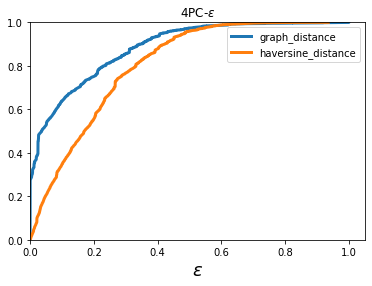

In [13]:
epsilon_cond_check()